








#Parkinson's Disease Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Library Imports

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile as zf
import os
import random
import cv2
import imutils
import pickle

from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
from sklearn.metrics import roc_auc_score, roc_curve

from skimage import feature

from keras.utils import to_categorical
from imutils import build_montages,paths
from google.colab.patches import cv2_imshow

sns.set()

#2. Data Loading

In [ ]:
meander_train_healthy=os.listdir('/content/drive/MyDrive/Dataset/handpd/Meander/Train/Healthy/')
meander_train_park = os.listdir('/content/drive/MyDrive/Dataset/handpd/Meander/Train/Parkinson/')

fp_meander_train_healthy = '/content/drive/MyDrive/Dataset/handpd/Meander/Train/Healthy/'
fp_meander_train_park = '/content/drive/MyDrive/Dataset/handpd/Meander/Train/Parkinson/'

meander_test_healthy = os.listdir('/content/drive/MyDrive/Dataset/handpd/Meander/Test/Healthy/')
meander_test_park = os.listdir('/content/drive/MyDrive/Dataset/handpd/Meander/Test/Parkinson/')

fp_meander_test_healthy = '/content/drive/MyDrive/Dataset/handpd/Meander/Test/Healthy/'
fp_meander_test_park = '/content/drive/MyDrive/Dataset/handpd/Meander/Test/Parkinson/'

#3. Feature Engineering Techniques
Three feature extraction methods are defined for processing the images:

Histogram of Oriented Gradients (HOG): Captures edge direction and intensity.
Local Binary Patterns (LBP): Used for texture analysis.
Haralick Textures: Extracts statistical texture features.

####Histogram of Oriented Gradients (HOG) technique

In [ ]:
def quantify_image(image):
  features = feature.hog(image,orientations=9,
                pixels_per_cell=(10,10),cells_per_block=(2,2),transform_sqrt=True,block_norm="L1")

  return features

####Local Binary Patterns (LBP) for Texture Analysis:

In [ ]:
from skimage.feature import local_binary_pattern
from skimage import feature

def quantify_image_lbp(image):
    features = local_binary_pattern(image, P=24, R=8, method="uniform")
    (hist, _) = np.histogram(features.ravel(),
                             bins=np.arange(0, 27),
                             range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist


####Haralick Textures:

In [ ]:
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 18.7 MB/s eta 0:00:00


In [ ]:
import mahotas as mt

def quantify_image_haralick(image):
    textures = mt.features.haralick(image)
    ht_mean = textures.mean(axis=0)
    return ht_mean


#4. Image Preprocessing and Feature Extraction For Hog FE Technique

In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in meander_train_healthy:
    image_path = (fp_meander_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    trainX.append(features)
    trainY.append('healthy')

for i in meander_train_park:

    image_path = (fp_meander_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in meander_test_healthy:

    image_path = (fp_meander_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    testX.append(features)
    testY.append('healthy')

for i in meander_test_park:


    image_path = (fp_meander_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[0.03536294, 0.        , 0.03750807, ..., 0.        , 0.        ,
        0.        ],
       [0.05283877, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02868289, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02868289, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
testX

array([[0.07397428, 0.        , 0.02989012, ..., 0.        , 0.        ,
        0.        ],
       [0.01159914, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10204171, 0.        , 0.01311898, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#5. Machine Learning Models

Several classification models are trained and evaluated:

Random Forest Classifier: An ensemble method for classification.

Decision Tree: A tree-based model for classification.

Support Vector Machine (SVM): A powerful classifier, especially effective in high-dimensional spaces.

Logistic Regression: A linear model for binary classification.

Naive Bayes: A probabilistic classifier based on Bayes' theorem.

Each model is trained on the extracted features and evaluated on the test set. Performance metrics like confusion matrix, sensitivity, specificity, and accuracy are calculated. Also, ROC curves and calibration curves are plotted to evaluate model performance.

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[31,  4],
       [ 6, 25]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

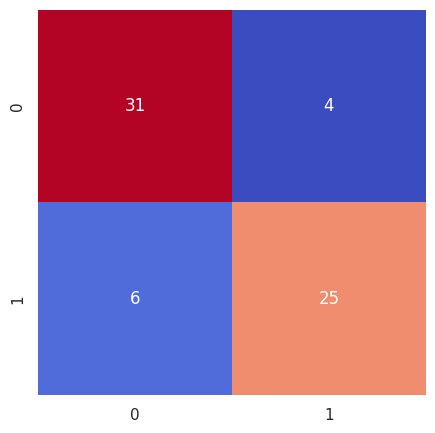

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.8484848484848485

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([12,  1,  5, 27, 25,  7,  1,  2,  0, 18, 27,  0, 11,  7,  0, 22, 12,
        7, 19,  1, 15,  6,  4, 24,  4])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['parkinson',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


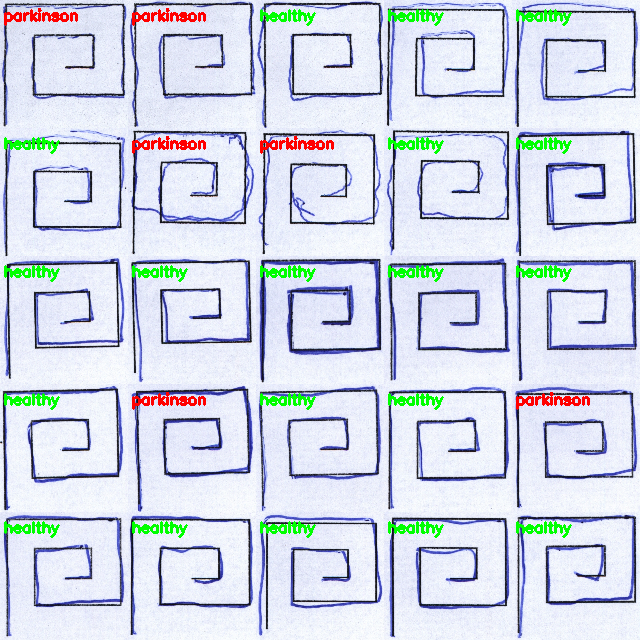

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[22, 13],
       [10, 21]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

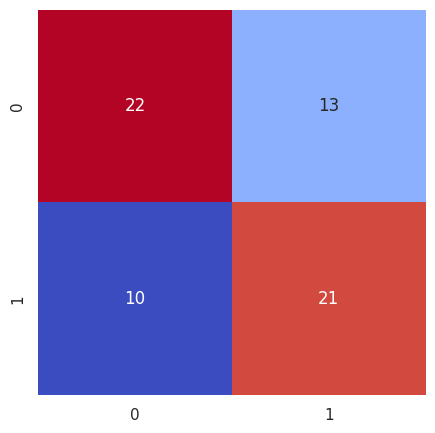

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.6515151515151515

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[31,  4],
       [ 4, 27]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

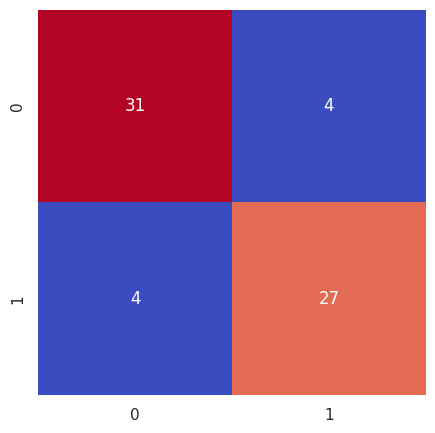

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.8787878787878788

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[31,  4],
       [ 3, 28]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.8939393939393939

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[27,  8],
       [15, 16]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.6515151515151515

No Skill AUC:  0.5
DecisionTree AUC:  0.652995391705069
Support Vector Machine AUC:  0.9179723502304148
Logistic Regression AUC:  0.9382488479262673
Gaussian Naive Bayes AUC:  0.6437788018433179


Text(0.5, 1.0, 'ROC curve')

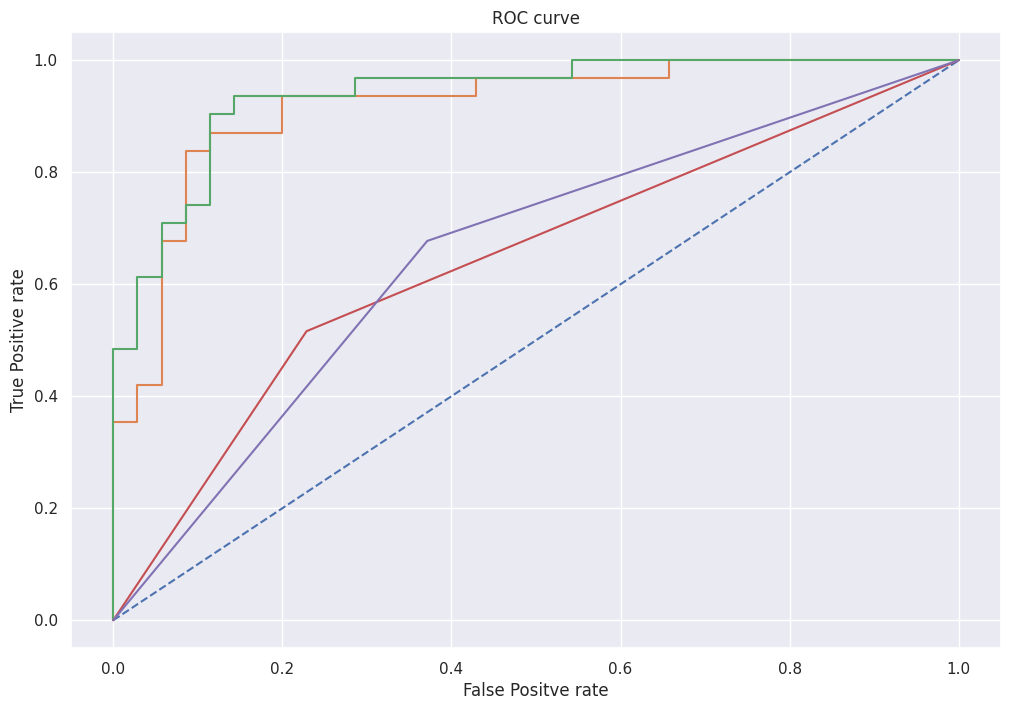

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)




fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


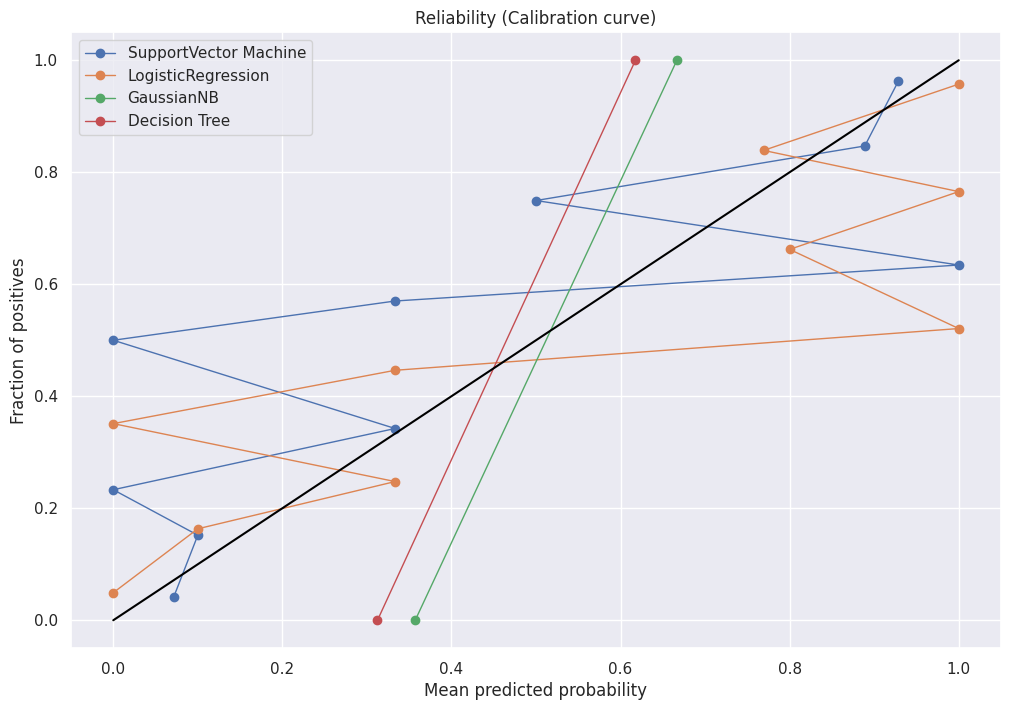

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
meander_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

meander_table = {}


for model in meander_model.keys():

    meander_pred = meander_model[model].predict(testX)
    accuracy = meander_model[model].score(testX,testY)
    meander_table[model] = [accuracy]

In [ ]:
meander_results = pd.DataFrame.from_dict(meander_table, orient='index')
meander_results.columns = columns
meander_results

accuracy
Random Forest           0.848485
Support Vector Machine  0.878788
Decision tree           0.651515
Gaussian Naive Bayes    0.651515
Logistic Regression     0.893939

#Local Binary Patterns


In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in meander_train_healthy:
    image_path = (fp_meander_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    trainX.append(features)
    trainY.append('healthy')
    # ... rest of your code ...



for i in meander_train_park:

    image_path = (fp_meander_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in meander_test_healthy:

    image_path = (fp_meander_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    testX.append(features)
    testY.append('healthy')

for i in meander_test_park:


    image_path = (fp_meander_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_lbp(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[3.50000e-04, 2.32500e-03, 9.50000e-04, ..., 0.00000e+00,
        8.98300e-01, 9.77750e-02],
       [0.00000e+00, 1.62500e-03, 8.75000e-04, ..., 0.00000e+00,
        8.90150e-01, 1.06975e-01],
       [5.00000e-05, 7.75000e-04, 9.00000e-04, ..., 0.00000e+00,
        8.87700e-01, 1.10075e-01],
       ...,
       [2.50000e-05, 9.00000e-04, 6.00000e-04, ..., 0.00000e+00,
        8.90600e-01, 1.07500e-01],
       [2.50000e-05, 9.00000e-04, 6.00000e-04, ..., 0.00000e+00,
        8.90600e-01, 1.07500e-01],
       [0.00000e+00, 5.75000e-04, 7.75000e-04, ..., 0.00000e+00,
        8.90825e-01, 1.07275e-01]])

In [ ]:
testX

array([[2.50000e-04, 1.92500e-03, 1.35000e-03, ..., 0.00000e+00,
        8.99250e-01, 9.62250e-02],
       [2.75000e-04, 2.05000e-03, 5.75000e-04, ..., 0.00000e+00,
        8.83050e-01, 1.13325e-01],
       [4.50000e-04, 3.42500e-03, 7.50000e-04, ..., 0.00000e+00,
        8.99900e-01, 9.53750e-02],
       ...,
       [2.50000e-05, 4.75000e-04, 5.25000e-04, ..., 0.00000e+00,
        8.73700e-01, 1.24650e-01],
       [7.50000e-05, 8.50000e-04, 7.00000e-04, ..., 0.00000e+00,
        8.91950e-01, 1.06250e-01],
       [0.00000e+00, 5.75000e-04, 7.75000e-04, ..., 0.00000e+00,
        8.90825e-01, 1.07275e-01]])

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[23, 12],
       [ 7, 24]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

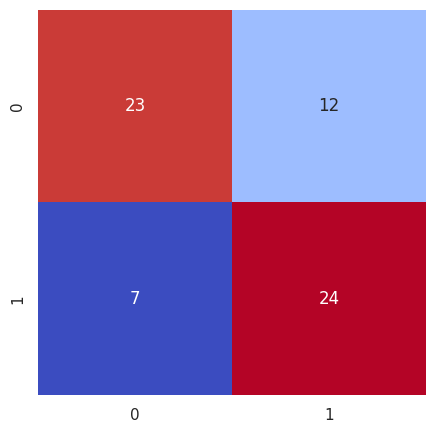

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.7121212121212122

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([20, 14, 21,  6,  1, 13, 19, 18, 26,  2,  0, 26,  9,  1, 20, 13, 25,
        4, 29, 14, 27,  9, 20, 22, 19])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'parkinson',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'parkinson',
 'parkinson',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


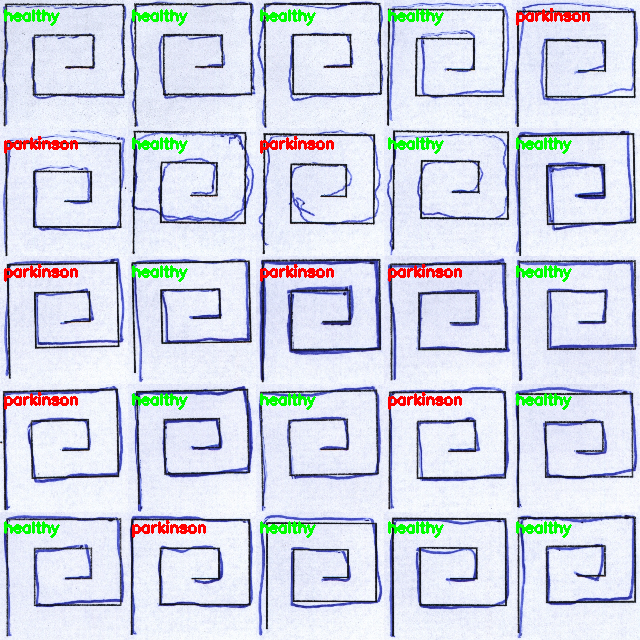

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[19, 16],
       [ 9, 22]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

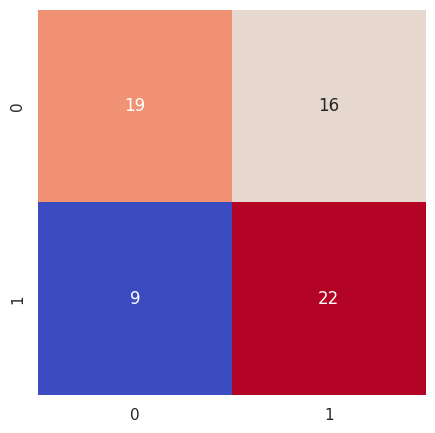

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.6212121212121212

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[35,  0],
       [31,  0]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

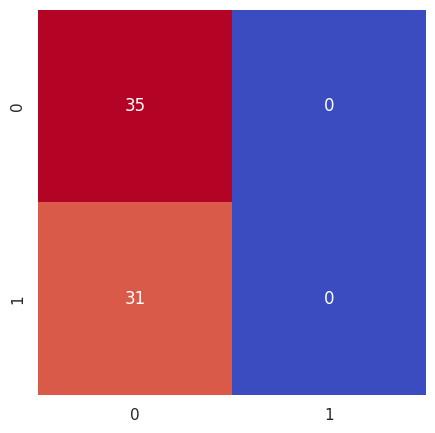

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.5303030303030303

In [ ]:
with open('/content/drive/MyDrive/meander_svm_model_pkl.pkl', 'wb') as files:
    pickle.dump(svm_mod, files)

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[35,  0],
       [31,  0]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.5303030303030303

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[ 1, 34],
       [ 0, 31]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.48484848484848486

No Skill AUC:  0.5
DecisionTree AUC:  0.6972350230414747
Support Vector Machine AUC:  0.5824884792626729
Logistic Regression AUC:  0.552073732718894
Gaussian Naive Bayes AUC:  0.6755760368663595


Text(0.5, 1.0, 'ROC curve')

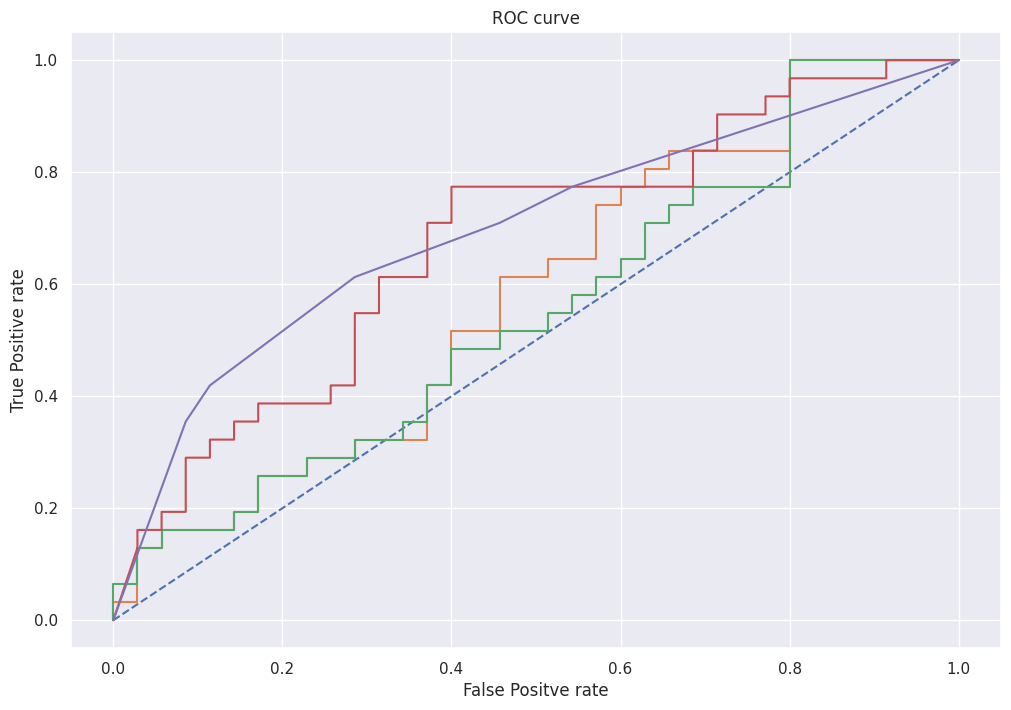

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)


fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


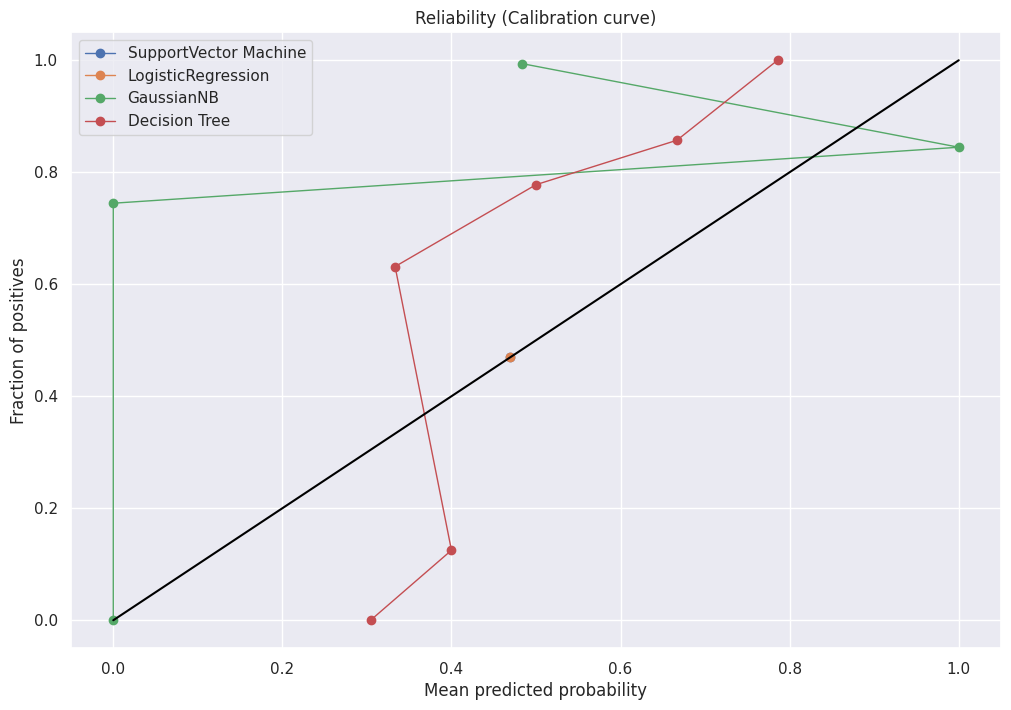

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
meander_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

meander_table = {}


for model in meander_model.keys():

   meander_pred = meander_model[model].predict(testX)
   accuracy = meander_model[model].score(testX,testY)
   meander_table[model] = [accuracy]

In [ ]:
meander_results = pd.DataFrame.from_dict(meander_table, orient='index')
meander_results.columns = columns
meander_results

accuracy
Random Forest           0.712121
Support Vector Machine  0.530303
Decision tree           0.621212
Gaussian Naive Bayes    0.484848
Logistic Regression     0.530303

In [ ]:
#

####Haralick Textures:

In [ ]:
!pip install mahotas

In [ ]:
import mahotas as mt

def quantify_image_haralick(image):
    textures = mt.features.haralick(image)
    ht_mean = textures.mean(axis=0)
    return ht_mean


In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in meander_train_healthy:
    image_path = (fp_meander_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    trainX.append(features)
    trainY.append('healthy')
    # ... rest of your code ...



for i in meander_train_park:

    image_path = (fp_meander_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in meander_test_healthy:

    image_path = (fp_meander_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    testX.append(features)
    testY.append('healthy')

for i in meander_test_park:


    image_path = (fp_meander_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_haralick(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[ 7.73854547e-01,  2.88039929e+03,  7.59305988e-01, ...,
         2.59488392e-01, -5.28946323e-01,  6.26639680e-01],
       [ 7.59553926e-01,  2.98047123e+03,  7.67297865e-01, ...,
         2.65968138e-01, -5.37212870e-01,  6.42707124e-01],
       [ 7.55045372e-01,  3.03036762e+03,  7.67876732e-01, ...,
         2.69519599e-01, -5.36603201e-01,  6.46221375e-01],
       ...,
       [ 7.65963726e-01,  2.57396440e+03,  7.98276564e-01, ...,
         2.38389450e-01, -5.81321967e-01,  6.62132348e-01],
       [ 7.65963726e-01,  2.57396440e+03,  7.98276564e-01, ...,
         2.38389450e-01, -5.81321967e-01,  6.62132348e-01],
       [ 7.60342286e-01,  2.99831981e+03,  7.64624708e-01, ...,
         2.67553417e-01, -5.32916931e-01,  6.40185060e-01]])

In [ ]:
testX

array([[ 7.76704633e-01,  2.78533958e+03,  7.65305049e-01,
         5.93068370e+03,  9.57165756e-01,  5.17704540e+01,
         2.09373952e+04,  6.50102019e-01,  6.92936922e-01,
         3.57159316e-03,  2.53049963e-01, -5.37523146e-01,
         6.29153351e-01],
       [ 7.38905350e-01,  3.68280559e+03,  7.27729452e-01,
         6.75923847e+03,  9.43364107e-01,  6.00948347e+01,
         2.33541483e+04,  7.37428467e-01,  7.94065231e-01,
         3.47538151e-03,  3.10786602e-01, -4.82154332e-01,
         6.25137646e-01],
       [ 7.70687095e-01,  3.29412272e+03,  7.20828253e-01,
         5.89671624e+03,  9.49341452e-01,  5.14364511e+01,
         2.02927422e+04,  6.67021052e-01,  7.17680379e-01,
         3.51641903e-03,  2.86946717e-01, -4.78674338e-01,
         5.99518910e-01],
       [ 7.32242003e-01,  3.21981383e+03,  7.75949658e-01,
         7.18133878e+03,  9.50484209e-01,  6.44754116e+01,
         2.55055413e+04,  7.47603387e-01,  7.97119940e-01,
         3.52475152e-03,  2.81423319e

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[26,  9],
       [ 8, 23]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

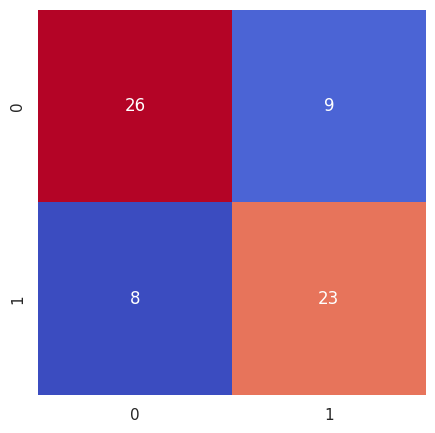

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.7424242424242424

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([ 6,  2, 21,  3, 23, 16, 15,  5,  7, 27, 27, 12, 17, 14, 23, 23, 28,
       10,  1, 26,  6,  6, 17,  1, 17])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'parkinson',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


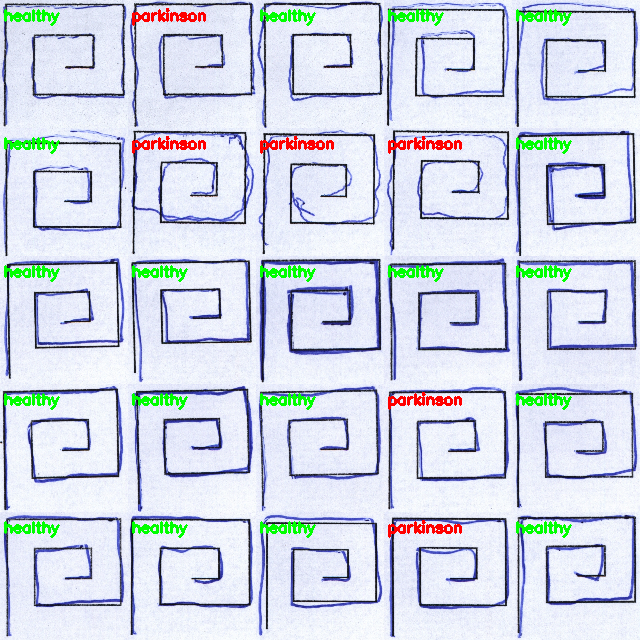

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[24, 11],
       [ 8, 23]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

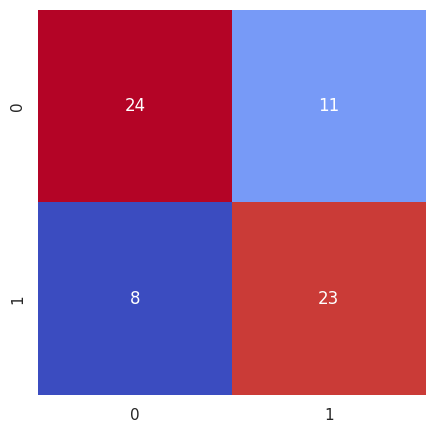

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.7121212121212122

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[35,  0],
       [31,  0]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

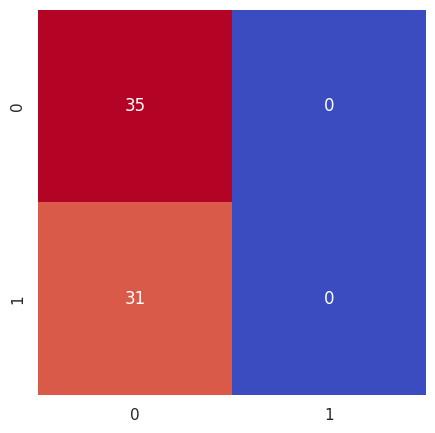

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.5303030303030303

In [ ]:
with open('/content/drive/MyDrive/meander_svm_model_pkl.pkl', 'wb') as files:
    pickle.dump(svm_mod, files)

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[19, 16],
       [17, 14]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.5

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[28,  7],
       [17, 14]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.6363636363636364

No Skill AUC:  0.5
DecisionTree AUC:  0.7304147465437788
Support Vector Machine AUC:  0.30138248847926263
Logistic Regression AUC:  0.6175115207373272
Gaussian Naive Bayes AUC:  0.7032258064516128


Text(0.5, 1.0, 'ROC curve')

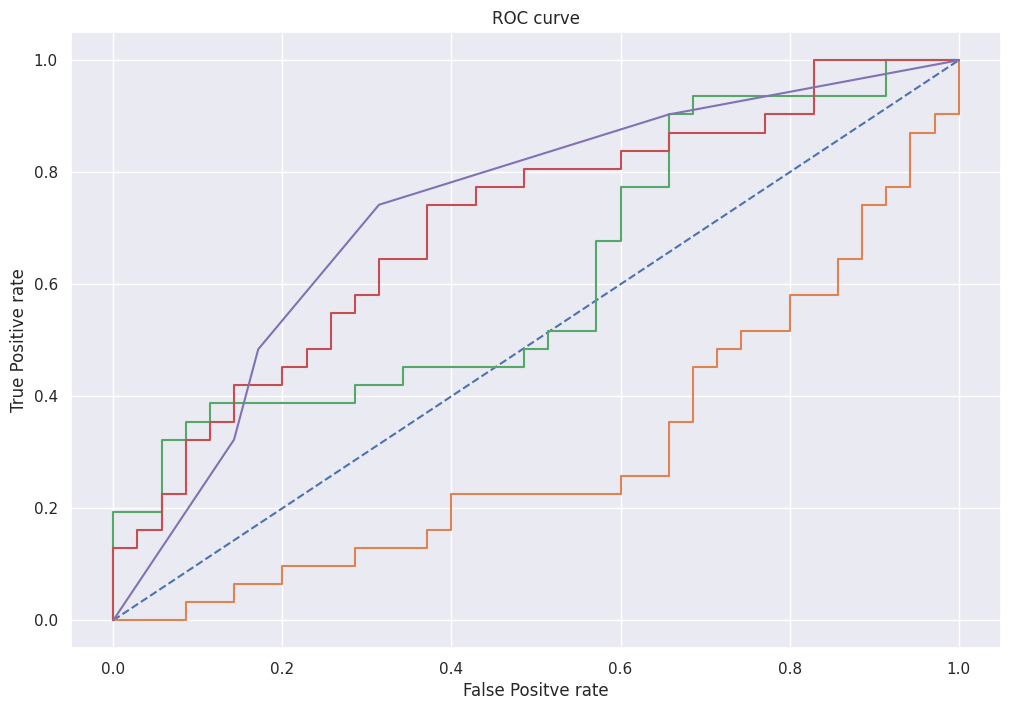

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)


fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


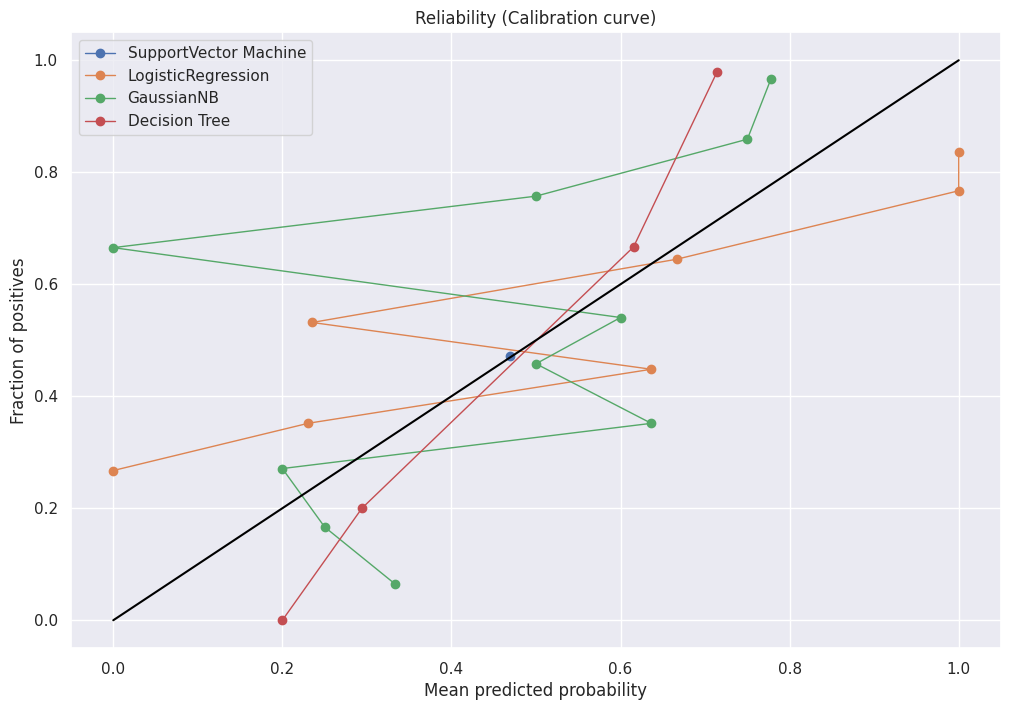

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
meander_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

meander_table = {}


for model in meander_model.keys():

    meander_pred = meander_model[model].predict(testX)
    accuracy = meander_model[model].score(testX,testY)
    meander_table[model] = [accuracy]

In [ ]:
meander_results = pd.DataFrame.from_dict(meander_table, orient='index')
meander_results.columns = columns
meander_results

accuracy
Random Forest           0.742424
Support Vector Machine  0.530303
Decision tree           0.712121
Gaussian Naive Bayes    0.636364
Logistic Regression     0.500000

In [ ]:
#Combinied HOG and LBP

In [ ]:
from skimage import feature
import numpy as np

def quantify_image_combined(image):
    # Extract HOG features
    hog_features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10),
                               cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

    # Extract LBP features
    lbp_features = feature.local_binary_pattern(image, P=24, R=8, method="uniform")
    (hist, _) = np.histogram(lbp_features.ravel(), bins=np.arange(0, 27), range=(0, 26))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Combine HOG and LBP features
    combined_features = np.concatenate((hog_features, hist))

    return combined_features


In [ ]:
trainX = []
testX = []
outputs = []
trainY = []
testY = []

for i in meander_train_healthy:
    image_path = (fp_meander_train_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image =cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    trainX.append(features)
    trainY.append('healthy')
    # ... rest of your code ...



for i in meander_train_park:

    image_path = (fp_meander_train_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    trainX.append(features)
    trainY.append('parkinson')

for i in meander_test_healthy:

    image_path = (fp_meander_test_healthy + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    testX.append(features)
    testY.append('healthy')

for i in meander_test_park:


    image_path = (fp_meander_test_park + i)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        continue
    outputs.append(image)
    image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image , (200,200))
    image = cv2.threshold(image ,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image_combined(image)
    testX.append(features)
    testY.append('parkinson')


In [ ]:
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)


In [ ]:
trainX


array([[0.03536294, 0.        , 0.03750807, ..., 0.        , 0.8983    ,
        0.097775  ],
       [0.05283877, 0.        , 0.        , ..., 0.        , 0.89015   ,
        0.106975  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.8877    ,
        0.110075  ],
       ...,
       [0.02868289, 0.        , 0.        , ..., 0.        , 0.8906    ,
        0.1075    ],
       [0.02868289, 0.        , 0.        , ..., 0.        , 0.8906    ,
        0.1075    ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.890825  ,
        0.107275  ]])

In [ ]:
testX

array([[0.07397428, 0.        , 0.02989012, ..., 0.        , 0.89925   ,
        0.096225  ],
       [0.01159914, 0.        , 0.        , ..., 0.        , 0.88305   ,
        0.113325  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.8999    ,
        0.095375  ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.8737    ,
        0.12465   ],
       [0.10204171, 0.        , 0.01311898, ..., 0.        , 0.89195   ,
        0.10625   ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.890825  ,
        0.107275  ]])

In [ ]:
trainY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 

In [ ]:
testY

array(['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson',
       'parkinson', 'parkinson', 'parkinson', 'parkinson', 'parkinson'],
      dtype='<U9')

In [ ]:
le = LabelEncoder()

In [ ]:
trainY = le.fit_transform(trainY)
testY = le.transform(testY)

In [ ]:
trainY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
testY

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#Random Forests

In [ ]:
model = RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(trainX,trainY)

RandomForestClassifier()

In [ ]:
preds = model.predict(testX)
preds

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds)
cnf

array([[31,  4],
       [ 3, 28]])

In [ ]:
sensitivity= 35/(35+9)
sensitivity

0.7954545454545454

In [ ]:
specificity= 22/(22+0)
specificity

1.0

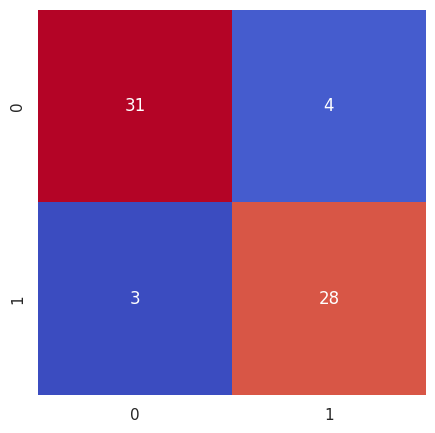

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc = metrics.accuracy_score(testY,preds)
acc

0.8939393939393939

In [ ]:
indexes = np.random.randint(0,30,25)
indexes

array([13, 28, 29,  4, 20, 26, 17, 26, 25, 16,  9,  1,  5, 16,  3, 19, 25,
        8, 15, 29, 15, 20,  0,  8, 10])

In [ ]:
labels = []

for i in indexes:
  pred = le.inverse_transform(preds)[i]
  labels.append(pred)

In [ ]:
labels

['parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'parkinson',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy']

In [ ]:
results = []

for i in range(25):
  image = outputs[i]

  if labels[i] == 'healthy':
    color = (0,255,0)
  else:
    color = (0,0,255)

  text = str(labels[i])

  image = cv2.resize(image,(128,128))
  cv2.putText(image,text,(3,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

  results.append(image)


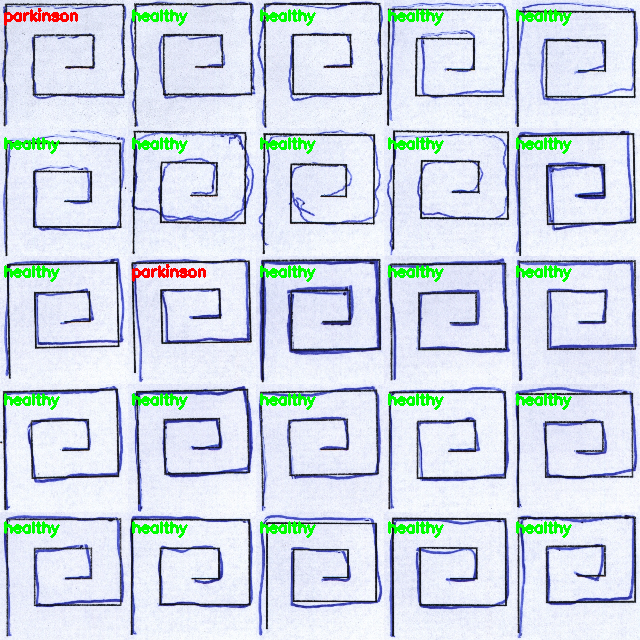

-1

In [ ]:
montage = build_montages(results,(128,128),(5,5))[0]

cv2_imshow(montage)
cv2.waitKey(0)

#Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7)
clf.fit(trainX,trainY)

DecisionTreeClassifier(max_depth=7)

In [ ]:
preds_dt = clf.predict(testX)
preds_dt

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,preds_dt)
cnf

array([[24, 11],
       [10, 21]])

In [ ]:
sensitivity=29/(29+10)
sensitivity

0.7435897435897436

In [ ]:
specificity=21/(21+6)
specificity

0.7777777777777778

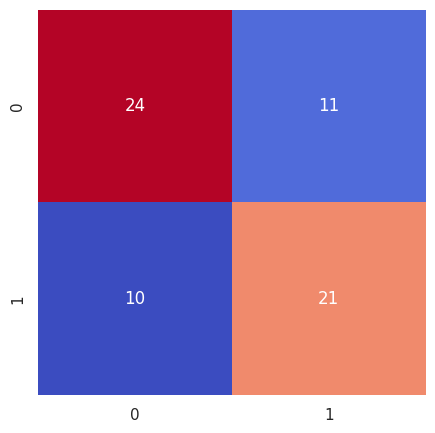

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_dt = metrics.accuracy_score(testY,preds_dt)
acc_dt

0.6818181818181818

#Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svm_mod = SVC(probability=True)
svm_mod.fit(trainX,trainY)

SVC(probability=True)

In [ ]:
pred_svc = svm_mod.predict(testX)
pred_svc

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
cnf = confusion_matrix(testY,pred_svc)
cnf

array([[31,  4],
       [ 4, 27]])

In [ ]:
sensitivity= 33/(33+4)
sensitivity

0.8918918918918919

In [ ]:
specificity=27/(27+2)
specificity

0.9310344827586207

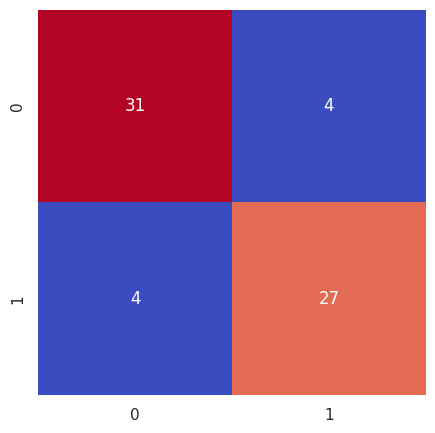

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [ ]:
acc_svc = metrics.accuracy_score(testY,pred_svc)
acc_svc

0.8787878787878788

In [ ]:
with open('/content/drive/MyDrive/meander_svm_model_pkl.pkl', 'wb') as files:
    pickle.dump(svm_mod, files)

# Logistic Regression

In [ ]:
lg_mod = LogisticRegression()
lg_mod.fit(trainX, trainY)

LogisticRegression()

In [ ]:
pred_lg = lg_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_lg)
cnf

array([[31,  4],
       [ 3, 28]])

In [ ]:
sensitivity=34/(34+6)
sensitivity

0.85

In [ ]:
specificity=25/(25+1)
specificity

0.9615384615384616

In [ ]:
acc_lg = metrics.accuracy_score(testY,pred_lg)
acc_lg

0.8939393939393939

# Naive Bayes

In [ ]:
gnb_mod = GaussianNB()
gnb_mod.fit(trainX, trainY)

GaussianNB()

In [ ]:
pred_nb = gnb_mod.predict(testX)

In [ ]:
cnf = confusion_matrix(testY,pred_nb)
cnf

array([[27,  8],
       [15, 16]])

In [ ]:
sensitivity=29/(29+15)
sensitivity

0.6590909090909091

In [ ]:
specificity=16/(16+6)
specificity

0.7272727272727273

In [ ]:
acc_nb = metrics.accuracy_score(testY,pred_nb)
acc_nb

0.6515151515151515

No Skill AUC:  0.5
DecisionTree AUC:  0.6815668202764976
Support Vector Machine AUC:  0.9179723502304148
Logistic Regression AUC:  0.9382488479262673
Gaussian Naive Bayes AUC:  0.6437788018433179


Text(0.5, 1.0, 'ROC curve')

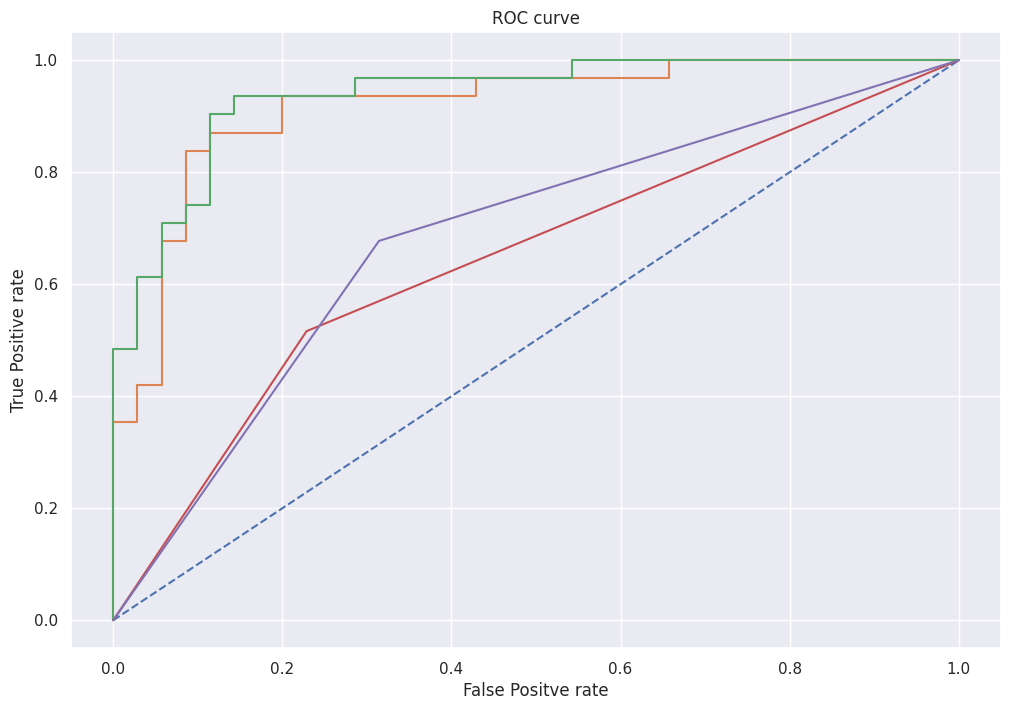

In [ ]:
no_skill_prob = [0 for _ in range(len(testY))]
no_skill_auc = roc_auc_score(testY, no_skill_prob)
print("No Skill AUC: ", no_skill_auc)
ns_fpr, ns_tpr, _ = roc_curve(testY, no_skill_prob)

dt_prob = clf.predict_proba(testX)[:,-1]
dt_auc = roc_auc_score(testY,dt_prob)
print("DecisionTree AUC: ", dt_auc)
dt_fpr, dt_tpr, _ = roc_curve(testY, dt_prob)

svm_prob = svm_mod.predict_proba(testX)[:,-1]
svm_auc = roc_auc_score(testY,svm_prob)
print("Support Vector Machine AUC: ", svm_auc)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_prob)

lg_prob = lg_mod.predict_proba(testX)[:,-1]
lg_auc = roc_auc_score(testY, lg_prob)
print("Logistic Regression AUC: ",lg_auc)
lg_fpr, lg_tpr, _ = roc_curve(testY, lg_prob)

nb_prob = gnb_mod.predict_proba(testX)[:,-1]
nb_auc = roc_auc_score(testY, nb_prob)
print("Gaussian Naive Bayes AUC: ", nb_auc)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_prob)


fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ns_fpr, ns_tpr, linestyle= '--', label= 'Reference')
ax.plot(svm_fpr, svm_tpr, linestyle= '-', label= 'SupportVectorMachine')
ax.plot(lg_fpr, lg_tpr, linestyle='-', label= 'LogisticRegression')
ax.plot(nb_fpr, nb_tpr, linestyle='-', label= 'GaussianNB')
ax.plot(dt_fpr, dt_tpr, linestyle='-', label= 'Decision Tree')

plt.xlabel('False Positve rate')
plt.ylabel('True Positive rate')
plt.title('ROC curve')


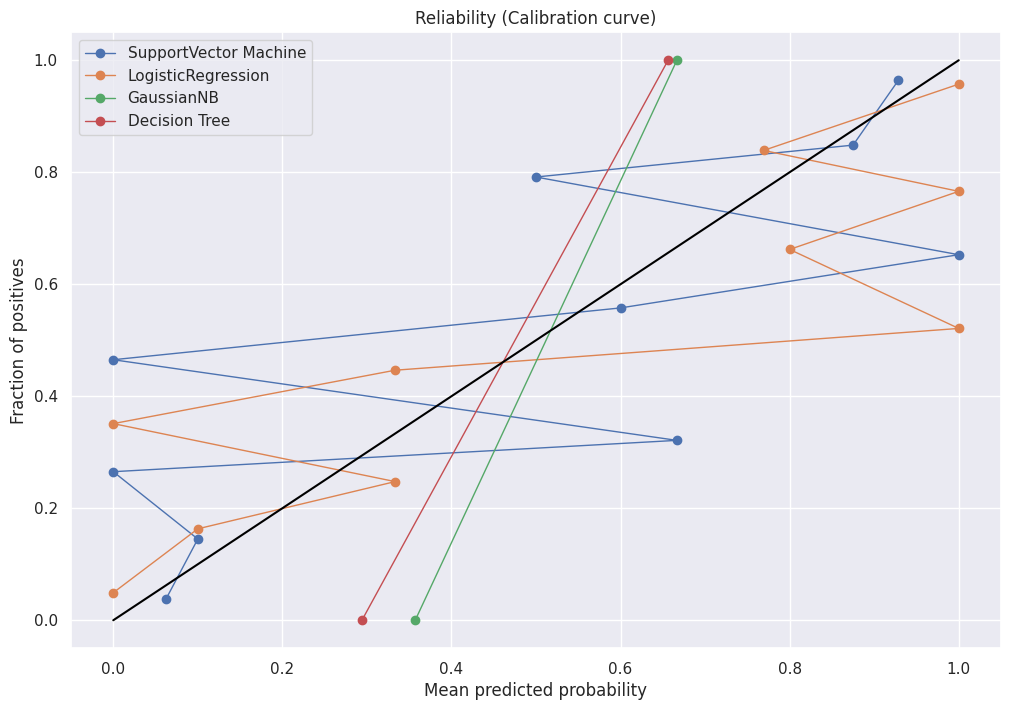

In [ ]:
sv_x, sv_y = calibration_curve(testY, svm_prob, n_bins=10)
lg_x, lg_y = calibration_curve(testY, lg_prob, n_bins=10)
nb_x, nb_y = calibration_curve(testY, nb_prob, n_bins=10)
dt_x, dt_y = calibration_curve(testY,dt_prob,n_bins=10)




fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sv_x, sv_y, marker= 'o', linewidth= '1', label= 'SupportVector Machine')
ax.plot(lg_x, lg_y, marker= 'o', linewidth= '1', label= 'LogisticRegression')
ax.plot(nb_x, nb_y, marker= 'o', linewidth= '1', label= 'GaussianNB')
ax.plot(dt_x, dt_y, marker= 'o', linewidth= '1', label= 'Decision Tree')




line = mlines.Line2D([0,1],[0,1], color='black')
ax.add_line(line)
ax.legend()
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability (Calibration curve)')
plt.show()

In [ ]:
meander_model = {
    'Random Forest': model,
    'Support Vector Machine': svm_mod,
    'Decision tree':clf,
    'Gaussian Naive Bayes': gnb_mod,
    'Logistic Regression': lg_mod

}

columns = [
    'accuracy'
]

meander_table = {}


for model in meander_model.keys():

    meander_pred = meander_model[model].predict(testX)
    accuracy = meander_model[model].score(testX,testY)
    meander_table[model] = [accuracy]

In [ ]:
meander_results = pd.DataFrame.from_dict(meander_table, orient='index')
meander_results.columns = columns
meander_results

accuracy
Random Forest           0.893939
Support Vector Machine  0.878788
Decision tree           0.681818
Gaussian Naive Bayes    0.651515
Logistic Regression     0.893939